# Bladder PT Plots
Plots to justify assumptions made in our bladder detection algorithm in PET scans.

In [ ]:
import os
import json
import cv2
import random
import glob
import re
import logging
from scipy import ndimage
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# specify name/path of dataset
img_dir = 'image_dataset'
!ln -s ../image_dataset image_dataset

# load global dict
json_file = os.path.join(img_dir, "global_dict.json")
with open(json_file) as f:
    imgs_anns = json.load(f)

In [ ]:
MODALITY = "PT"
ROI = "Bladder"
bladder_indices = []

# set dimensions of PT scan frames
HEIGHT = 192
WIDTH = 192
sum_mask = np.zeros((HEIGHT, WIDTH))

# iterate over each specified patient
for idx, patient in enumerate(tqdm(imgs_anns.keys())):
    mod_obj = imgs_anns[patient][MODALITY]
    roi = mod_obj['rois'][ROI]

    # get range of frames which contain the bladder
    bladder_range = np.array([idx for idx, i in enumerate(roi) if i])
    # add bladder range to list
    bladder_indices.extend(bladder_range / len(roi))

    # get all file paths for frames
    all_frame_fp = glob.glob(mod_obj['fp'] + "/*.jpeg")

    # iterate over each frame
    for jdx, frame_fp in enumerate(all_frame_fp):
        # get the slice number of frame jpeg
        slice_num = int(re.findall(r'\d+', frame_fp)[-1])

        # skip if slice number is not inside bladder range
        if slice_num not in bladder_range:
            continue

        img = cv2.imread(frame_fp, 0)
        height, width = img.shape
        assert (height, width) == (HEIGHT, WIDTH)
        
        # initialize mask 2d array
        mask = np.zeros((width, height))
        # list to store poly coords
        polys = []

        # get contours
        contours = roi[slice_num]

        # iterate over each set of x,y polygon coordinates
        for item in contours:
            item = np.array(item).astype(int)
            # convert list of tuples to list e.g. [x1,y1,x2,y2]
            polys.extend([int(val) for t in item for val in t])

        indices = np.arange(0, len(polys), 2)
        # generate mask outline from poly coords
        for i in indices:
            # matrix element is indexed by first row number (y coord) then column number (x coord)
            mask[polys[i+1], polys[i]] = 1

        # assert mask size same as image size
        assert np.shape(mask) == np.shape(img)

        # fill in the holes of the mask
        mask = ndimage.binary_fill_holes(mask).astype(int)

        # update mask summation
        sum_mask += mask

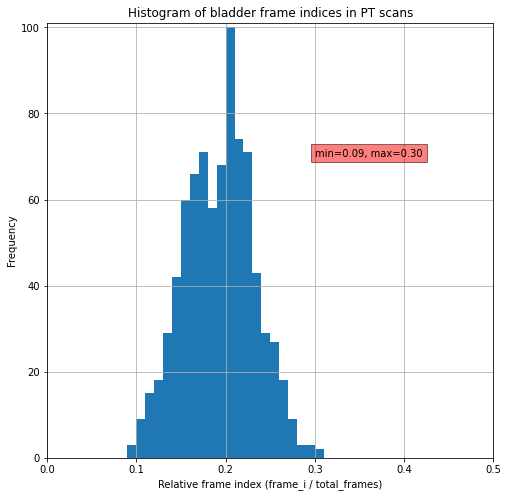

In [150]:
# plot distribution of bladder indices as histogram
plt.figure(figsize=(8,8))
_, bins, _ = plt.hist(bladder_indices, bins=50, range=[0,.5], density=False)

# fix axes, add titles, and save figure
plt.xlabel("Relative frame index (frame_i / total_frames)")
plt.ylabel("Frequency")
plt.xlim(0, 0.5)
plt.ylim(0, 101)
plt.grid(True)
plt.title("Histogram of bladder frame indices in PT scans")
plt.text(0.3, 70, 'min=%.02f, max=%0.2f' % (min(bladder_indices), max(bladder_indices)), bbox=dict(facecolor='red', alpha=0.5))
plt.savefig("bladder_frames_hist.pdf")

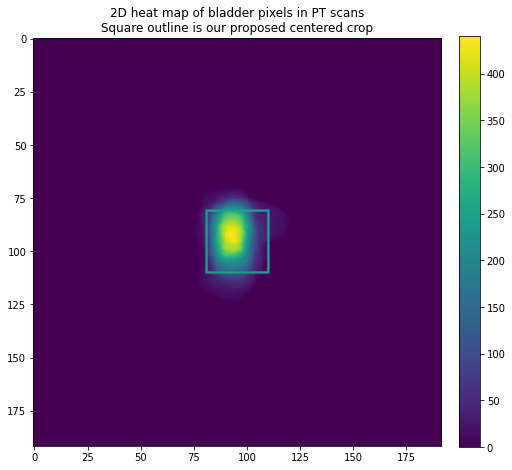

In [151]:
# init new plot
plt.figure(figsize=(8,8))

# get the x and y center points of frame
center_x = HEIGHT/2
center_y = WIDTH/2

# set crop size
crop_size = np.round(0.15*HEIGHT)

# make a copy of sum mask image
img_copy = sum_mask.copy()

# create a square contour which is centered in the middle of the frame
square_contour = [np.array([[[center_x - crop_size/2, center_y - crop_size/2],
                             [center_x - crop_size/2, center_y + crop_size/2],
                             [center_x + crop_size/2, center_y + crop_size/2],
                             [center_x + crop_size/2, center_y - crop_size/2]]], dtype=np.int32)]

# draw square contour onto sum mask
cv2.drawContours(img_copy, square_contour, -1,(255,255,255),1)

# show image as 2d heat map
plt.imshow(img_copy)

# add title and save figure
plt.title("2D heat map of bladder pixels in PT scans\nSquare outline is our proposed centered crop")
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig("bladder_heatmap.pdf")